# Hog+CH+lbp_with_knn

## import libraries

In [3]:
import numpy as np
import cv2
import tensorflow as tf
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from sklearn.decomposition import PCA 
from skimage import exposure
from skimage import feature

## Load the Caltech101 dataset


In [5]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)

## Split the dataset into training and testing sets


In [7]:
train_data = dataset['train']
test_data = dataset['test']

## Resize with padding function


In [9]:
def resize_with_padding(image, target_size=(64, 64)):
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    delta_w = target_size[1] - resized_image.shape[1]
    delta_h = target_size[0] - resized_image.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

## Process the dataset


In [11]:
def process_data(data, image_size=(64, 64)):
    images = []
    labels = []

    for image, label in data:
        # Resize with padding
        image_resized = resize_with_padding(image.numpy(), image_size).astype('float32') / 255.0
        images.append(image_resized)
        labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

## Preprocess the training and testing datasets


In [13]:
X_train, y_train = process_data(train_data, image_size=(64, 64))
X_test, y_test = process_data(test_data, image_size=(64, 64))

## Feature extraction using HOG only


In [15]:
def extract_combined_features(image, image_size=(64, 64), bins=32):
    # Convert image to BGR format
    image = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
    
    # 1. Color Histogram Features
    color_features = []
    for channel in range(3):  # B, G, R channels
        hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        color_features.extend(hist)

    # 2. LBP Features
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Convert grayscale image to uint8 before applying LBP
    gray_image = np.uint8(gray_image)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    
    # 3. HOG Features (using custom function)
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog_descriptor = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog_descriptor.compute(gray_image).flatten()

    # Concatenate all features into a single feature vector
    combined_features = np.hstack((color_features, lbp_hist, hog_features))
    
    return combined_features

## Feature extraction for training and testing datasets using combined features


In [17]:
def extract_features(images, image_size=(64, 64), bins=32):
    features = []
    for image in images:
        features.append(extract_combined_features(image, image_size, bins))
    return np.array(features)

## Extract combined features for training and testing datasets


In [19]:
features_train = extract_features(X_train, image_size=(64, 64), bins=32)
features_test = extract_features(X_test, image_size=(64, 64), bins=32)

## Apply PCA for dimensionality reduction

In [21]:
def apply_pca(features_train, features_test, n_components=100):
    pca = PCA(n_components=n_components)  # Number of components to keep
    features_train_reduced = pca.fit_transform(features_train)
    features_test_reduced = pca.transform(features_test)
    
    return features_train_reduced, features_test_reduced, pca

## Reduce the dimensionality of the features using PCA

In [23]:
features_train_reduced, features_test_reduced, pca_model = apply_pca(features_train, features_test, n_components=100)

## Implement KNN classifier


In [25]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Implement KNN classifier
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # Compute the distances to all training samples
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Get the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common label among neighbors
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


## Train and predict with KNN


In [27]:
classifier = KNN(k=5)
classifier.fit(features_train_reduced, y_train.flatten())
y_pred = classifier.predict(features_test_reduced)

## Evaluate the classifier


In [29]:
accuracy = accuracy_score(y_test.flatten(), y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 56.22%


## Print classification report


In [31]:
print("\nClassification Report:")
print(classification_report(y_test.flatten(), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.61        25
           1       0.97      0.93      0.95       770
           2       0.21      0.25      0.23        12
           3       0.00      0.00      0.00        12
           4       0.66      0.09      0.15       438
           5       0.19      0.41      0.26        17
           6       0.12      0.17      0.14        24
           7       0.04      0.06      0.05        16
           8       0.00      0.00      0.00         3
           9       0.31      0.28      0.29        98
          10       0.33      0.38      0.36        68
          11       0.17      0.15      0.16        13
          12       0.40      0.49      0.44        55
          13       0.67      0.23      0.34        61
          14       0.38      0.15      0.21        20
          15       0.05      0.15      0.07        13
          16       0.93      0.99      0.96        93
   

## Visualize a random image, its HOG features, and the KNN prediction


In [55]:
from skimage import exposure  # Add this import at the beginning of your code

def show_image_with_features_and_predictions(images, labels, classifier, pca_model, image_size=(64, 64)):
    # Randomly choose an index
    idx = np.random.choice(len(images))
    
    # Extract image and its corresponding label using the index
    image = images[idx]
    label = labels[idx]
    
    # Resize image to the desired size
    resized_image = resize_with_padding(image, target_size=image_size)

    # Extract all features
    combined_features = extract_combined_features(resized_image, image_size=image_size, bins=32)
    
    # Apply PCA transformation to the features
    combined_features_reduced = pca_model.transform([combined_features])
    
    # Make prediction using the classifier
    prediction = classifier.predict(combined_features_reduced)[0]
    
    # Plot the original image
    plt.subplot(2, 3, 1)
    plt.imshow(resized_image)
    plt.title(f"True Label: {label}")
    plt.axis('off')
    
    # Plot color histograms
    plt.subplot(2, 3, 2)
    color_features = combined_features[:3 * 32]  # Get the first part of features (Color Hist)
    color_features = color_features.reshape(3, 32)  # Reshape to 3 channels x bins
    plt.bar(range(32), color_features[0], color='b', alpha=0.5, label="Blue")
    plt.bar(range(32), color_features[1], color='g', alpha=0.5, label="Green")
    plt.bar(range(32), color_features[2], color='r', alpha=0.5, label="Red")
    plt.title("Color Histograms")
    plt.legend()
    
    # Plot LBP features as histogram
    plt.subplot(2, 3, 3)
    lbp_hist = combined_features[3 * 32:3 * 32 + 32]  # Get the LBP Hist
    plt.bar(range(32), lbp_hist)
    plt.title("LBP Features")
    
    # Plot the LBP image (texture visualization)
    plt.subplot(2, 3, 4)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Convert to uint8 for LBP
    gray_image = np.uint8(gray_image)
    
    # Apply LBP and calculate the LBP image (texture map)
    radius = 1  # Radius of the circular region around each pixel
    n_points = 8 * radius  # Number of neighbors
    lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Plot LBP image
    plt.imshow(lbp_image, cmap=plt.cm.gray)
    plt.title("LBP Image")
    plt.axis('off')
    
    # Plot HOG Features
    plt.subplot(2, 3, 5)
    # Use skimage.feature.hog to compute HOG features and the HOG image
    fd, hog_image = feature.hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Rescale the HOG image for visualization purposes
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title("HOG Image")
    plt.axis('off')
    
    # Plot the predicted label
    plt.subplot(2, 3, 6)
    plt.imshow(resized_image)
    plt.title(f"Predicted: {prediction}")
    plt.axis('off')
    
    plt.show()


## Show image with HOG features and prediction


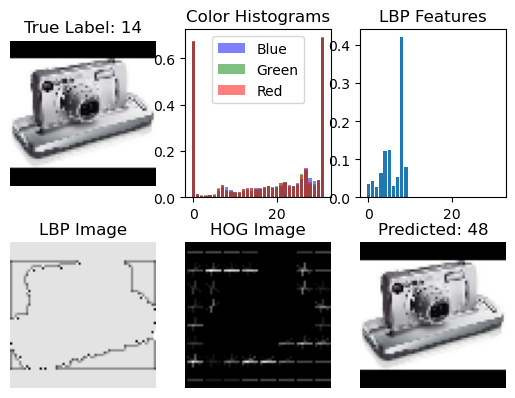

In [61]:
show_image_with_features_and_predictions(X_test, y_test, classifier, pca_model)